### **Database selection stage**

The MIT-BIH Arrhythmia Database is a set of 30 minutes heart rhythm recordings from 47 patients from 1975 to 1979. The data is from a range of healty to hearth-diseased patients. But the dataset is slightly imbalanced towards patients with heart problems.


The first step is download the dataset from the official site: https://www.physionet.org/content/mitdb/1.0.0/

In order to read the data correctly, I will use the WFDB (Waveform Database) library: https://wfdb.io/

In [149]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import neurokit2 as nk
import random

print(wfdb.__version__)

4.2.0


#### **Let's visualise!**

I will use the `plot_wfdb` method to plot the ECG of patient #100. 

For a clearer visualization, I will focus on the first 1000 samples of the ECG signal. Given that the sampling frequency of the MIT-BIH Arrhythmia Database is 360 Hz, this corresponds to the first 2.78 seconds of the patient's ECG signal.

The duration in seconds is given by:
$$\text{seconds} = \frac{\text{number of samples}}{\text{sampling frequency}} = \frac{1000}{360} \approx 2.78 \text{ seconds}$$

* https://wfdb.readthedocs.io/en/latest/plot.html

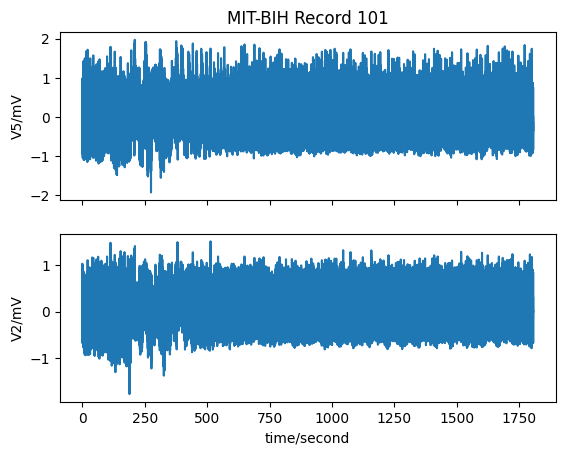

In [150]:
patient_record = wfdb.rdrecord("mit-bih-arrhythmia-database-1.0.0\\104",) # , sampfrom=72000, sampto=90000
wfdb.plot_wfdb(patient_record, title='MIT-BIH Record 101', time_units='seconds') # Plots the ECG

We can clearly see the first 4 QRS complex.

Let's move on, with `__dict__` returns a dictionary that holds all of the ECG data. We can see a lot of information here. 
* The top chunk of data tells us:
    * The patient number (`record_name`)
    * The number of leads recorded (`n_sig`)
    * Other info about the patient
* The middle chuck is there the ECG data is (i.e. the voltages of the leads). In this case we have 2 leads:
    * MLII (Modified Lead II)
    * V5 (Precordial Lead V5)
  
  MLII and V5 are two different types of ECG signals obtained from two different types of lead configurations.
    * More info here: https://www.washingtonhra.com/ekg-monitoring/12-lead-electrocardiogram-ekg.php
* The last chunk tell us more about about the voltage, units, data format, etc.

In [151]:
print(patient_record.__dict__)

{'record_name': '104', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['66 F 1567 694 x1', 'Digoxin, Pronestyl', 'The rate of paced rhythm is close to that of the underlying sinus rhythm,', 'resulting in many pacemaker fusion beats.  The PVCs are multiform.  Several', 'bursts of muscle noise occur, but the signals are generally of good quality.'], 'sig_name': ['V5', 'V2'], 'p_signal': array([[-0.15 ,  0.2  ],
       [-0.15 ,  0.2  ],
       [-0.15 ,  0.2  ],
       ...,
       [-0.065,  0.2  ],
       [-0.06 ,  0.205],
       [ 0.   ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['104.dat', '104.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [994, 1064], 'checksum': 

This data can also be accessed via dot notation:

In [152]:
print(f"Patient number: {patient_record.record_name}")
print(f"Leads: {patient_record.sig_name}")
print(f"ECG data: {patient_record.p_signal}")

Patient number: 104
Leads: ['V5', 'V2']
ECG data: [[-0.15   0.2  ]
 [-0.15   0.2  ]
 [-0.15   0.2  ]
 ...
 [-0.065  0.2  ]
 [-0.06   0.205]
 [ 0.     0.   ]]


In [153]:
#print(patient_record.p_signal[:,0])
type(patient_record.p_signal), len(patient_record.p_signal)

(numpy.ndarray, 650000)

In [154]:
annotations = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0\\104', 'atr')  # path to the .atr file
print("Annotazioni (simboli) per Record 100:", annotations.symbol)
valid_symbols = [symbol for symbol in annotations.symbol if symbol != '+']
valid_samples = [sample for sample, symbol in zip(annotations.sample, annotations.symbol) if symbol != '+']

"""valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}  # Aggiungi quelli che ti servono

# Filtra le annotazioni per tenere solo i battiti validi
valid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]
filtered_samples = annotations.sample[valid_indices]  # Posizioni dei battiti
filtered_symbols = np.array(annotations.symbol)[valid_indices]  # Etichette dei battiti

print(f"Numero di battiti trovati: {len(filtered_symbols)}")"""

Annotazioni (simboli) per Record 100: ['+', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', '~', 'f', 'f', '/', '/', '~', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '~', '/', '+', 'Q', 'Q', 'Q', '+', '/', '/', '~', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', '/', 'N', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', 'f', '/', '/', '/', '/', '/', '/', '+', 'N', 'N', 'f', 'f', '+', '/', '/', '/', '/', '/', '/', 'N', 'f', 'f', '/', '/', '/', '~', '/', '/', '/', 'N', 'f', '/', '/', '/', '/', '/', '/', 'N', 'f', 'f', '~', '/', '/', '/', '/', '/', '/', 'f', 'N', 'f', 'f', '/', '/', '/', '/', '/', '/', '/', 'f', 'N', 'f', 'f', '/', '/', '/', '/', '/', '/', '/', '/', 'f', 'N', 'f', 'f', 'f', '~', 'f', '/', '/', '/', '/', '

'valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}  # Aggiungi quelli che ti servono\n\n# Filtra le annotazioni per tenere solo i battiti validi\nvalid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]\nfiltered_samples = annotations.sample[valid_indices]  # Posizioni dei battiti\nfiltered_symbols = np.array(annotations.symbol)[valid_indices]  # Etichette dei battiti\n\nprint(f"Numero di battiti trovati: {len(filtered_symbols)}")'

### **Preprocessing stage**

Data preprocessing is a critical phase in arrhythmia detection. It involves cleaning and organasing the ECG data to make it suitable for machine learning/deep learning models.

I will split the preprocessing in 3 main steps:
* **Filtering**: ECG signals are susceptible to noise from various sources, including power line interference, muscle artifacts, and baseline wander. To enhance the signal quality, it is necessary applied filters. Typically these types of noises are located in the low frequency band of the frequency spectrum.


In [155]:
def high_pass_filter(original_signal, cutoff_frequency=0.5, sampling_rate=360, order=3):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = sp.signal.butter(order, normal_cutoff, btype='highpass', analog=False)
    filtered_signal = sp.signal.filtfilt(b, a, original_signal)
    return filtered_signal

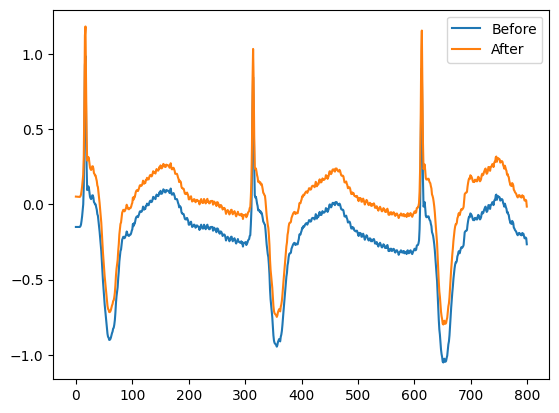

In [156]:
# Removing baseline wandering
filteredHighPassSignal = high_pass_filter(patient_record.p_signal[:,0]) # Select the first lead
plt.plot(patient_record.p_signal[:,0][:800])
plt.plot(filteredHighPassSignal[:800])
plt.legend(("Before", "After"))
plt.show()

Another source of noise would be the power line interference. It occurs at 50-60Hz and is caused by fluctuations in the electrical grid.

Since I don't know if this type of noise is present in this dataset I can do a spectral analysis. To do this:
- I will apply the Fourier Transform (FFT): this transform allows you to go from the time domain (where we see the signal as it varies over time) to the frequency domain (where we see the frequency components of the signal).
- I will observe the peaks: if there are peaks at 50 Hz or 60 Hz, it is likely that there is interference from power lines and I will proceed with the removal.

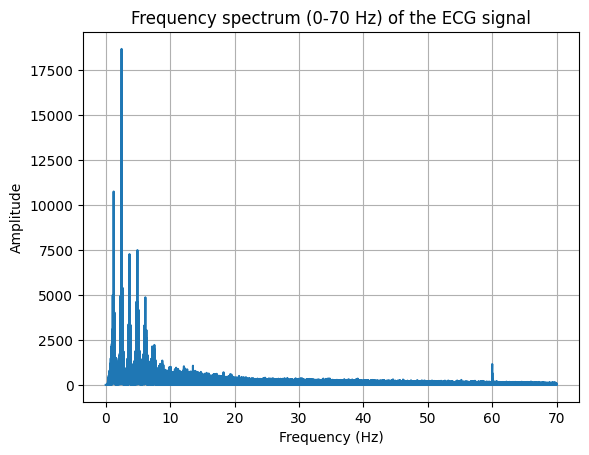

In [157]:
sampling_rate = 360  # Sampling rate in Hz

# Calculate FFT of the signal
fft_data = np.fft.fft(filteredHighPassSignal)  # Select the first lead
frequencies = np.fft.fftfreq(len(filteredHighPassSignal), d=1/sampling_rate)

# Find the indices corresponding to the positive frequencies
positive_frequencies = frequencies[:len(frequencies)//2]
positive_fft_data = np.abs(fft_data[:len(fft_data)//2])

# Filter for frequencies between 40 and 70 Hz
freq_range = (positive_frequencies >= 0) & (positive_frequencies <= 70)
filtered_frequencies = positive_frequencies[freq_range]
filtered_fft_data = positive_fft_data[freq_range]

# Displays the frequency spectrum between 40 and 70 Hz
plt.plot(filtered_frequencies, filtered_fft_data)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

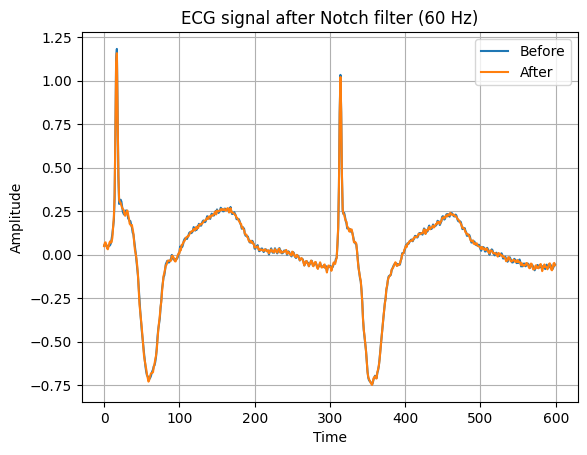

In [158]:
notch_frequency = 60  # In Hz
quality_factor = 30  # The higher the quality factor, the sharper the filter

# Calculate the notch filter coefficients
b, a = sp.signal.iirnotch(notch_frequency / (sampling_rate / 2), quality_factor)

# Filters the signal to remove 60Hz interference
filtered_data_notch = sp.signal.filtfilt(b, a, filteredHighPassSignal)  

# Plot
plt.plot(filteredHighPassSignal[:600])
plt.plot(filtered_data_notch[:600])
plt.title("ECG signal after Notch filter (60 Hz)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

As we can see the new filtered signal is much smoother than the pre-notch filter.

Finally, I will use a low-pass filter in order to cut the high frequencies. Usually an frequency's ECG signal is between 0.5-150 Hz, so I will cut all the frequency above 150 Hz.

In [159]:
def low_pass_filter(data, cutoff_freq=150, sampling_rate=360, order=3):
    nyquist = 0.5 * sampling_rate  
    normal_cutoff = cutoff_freq / nyquist  
    b, a = sp.signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = sp.signal.filtfilt(b, a, data)
    return filtered_data

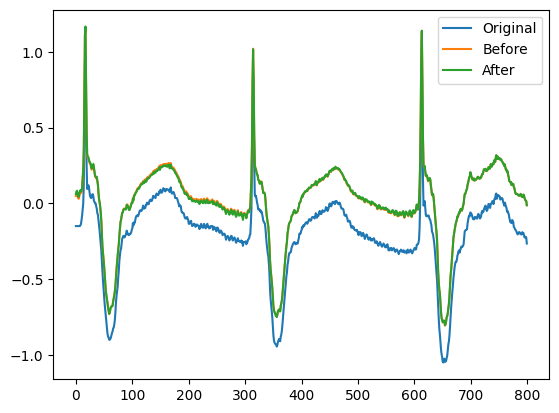

In [160]:
# Removing high frequencies > 150
filteredSignalFinal = high_pass_filter(filtered_data_notch)
plt.plot(patient_record.p_signal[:,0][:800])
plt.plot(filtered_data_notch[:800])
plt.plot(filteredSignalFinal[:800])
plt.legend(("Original", "Before", "After"))
plt.show()


* **Segmentation**: write a small introduction for the next stage

### **Segmentation stage**

Segmentation is the last part of the preprocessing which is extremely related to the way the database is structured and the choice of the deep learning model (which will be an LSTM model).
The MIT-BIH database offers labels for each heartbeat of the patient. The goal will be to segment the patients' ECG signals in such a way that each segment contains only one heartbeat, and assign it the associated label in the database.

The model will then predict, based on the segment, the type of arrhythmia of the heartbeat (segment).

To obtain segments each containing a single beat, a valid approach would be to identify the R peaks and then isolate the right and left sides of the R peak based on a normalized distance.

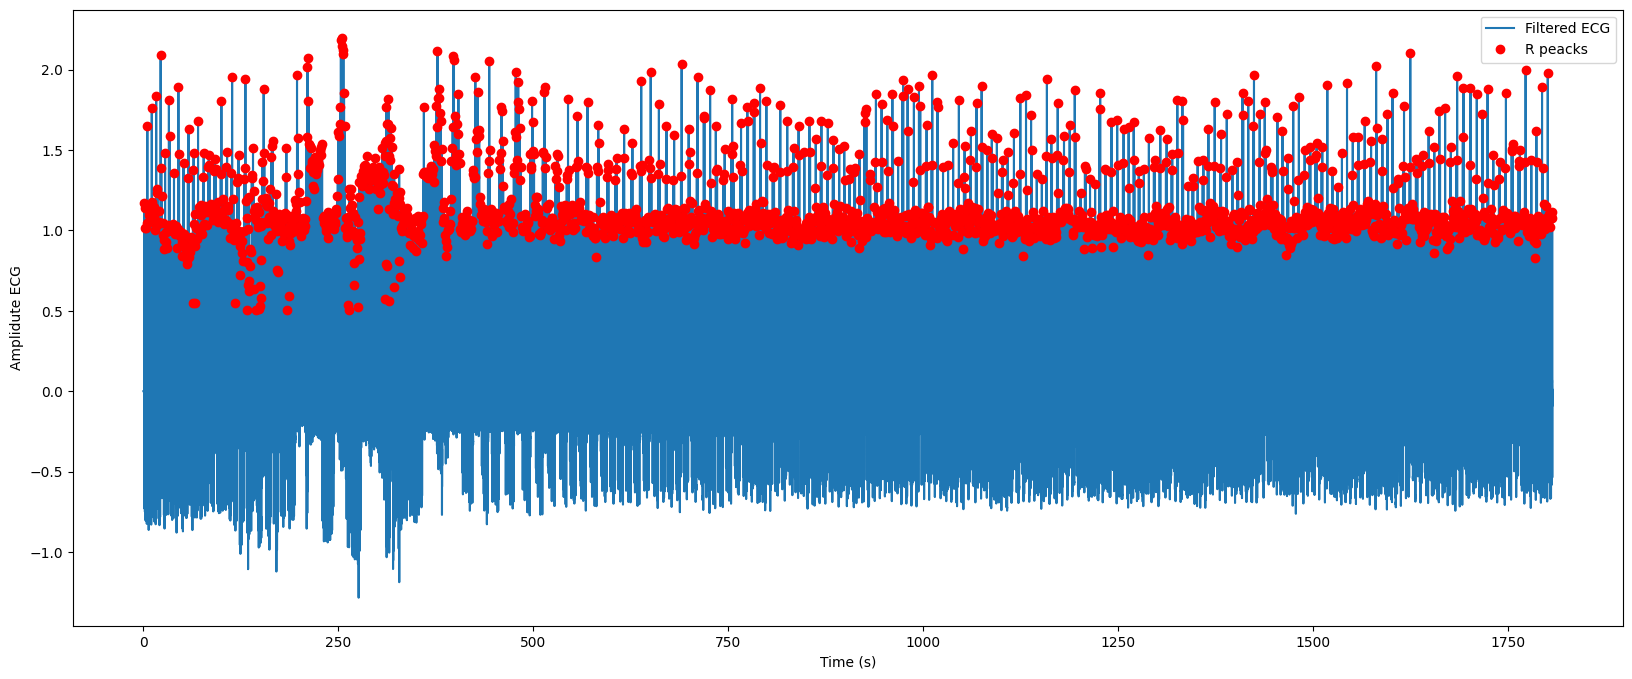

In [161]:
fs = 360  # Sampling rate (e.g. MIT-BIH)

# Add 1 second of padding both left and right
padding_length = fs  # Add 1 seconds of zeros
filteredSignalFinal_padded = np.concatenate((np.zeros(padding_length), filteredSignalFinal))  #, np.zeros(padding_length) Padding left and right

# Identifying peaks
peaks, _ = sp.signal.find_peaks(filteredSignalFinal_padded, height=0.5, distance=fs//4)  # Minimum height and distance between peaks
#signals, info = nk.ecg_process(filteredSignalFinal, sampling_rate=360, method="engzeemod2012")
#peaks = info['ECG_R_Peaks']

# Creating the time axis
t = np.arange(len(filteredSignalFinal_padded)) / fs  # Time in seconds

# Plot
plt.figure(figsize=(20, 8))
plt.plot(t, filteredSignalFinal_padded, label="Filtered ECG")  # X-axis: time
plt.plot(t[peaks], filteredSignalFinal_padded[peaks], "ro", label="R peacks")  # Use t[peaks] to align the x's
plt.xlabel("Time (s)")
plt.ylabel("Amplidute ECG")
plt.legend()
plt.show()

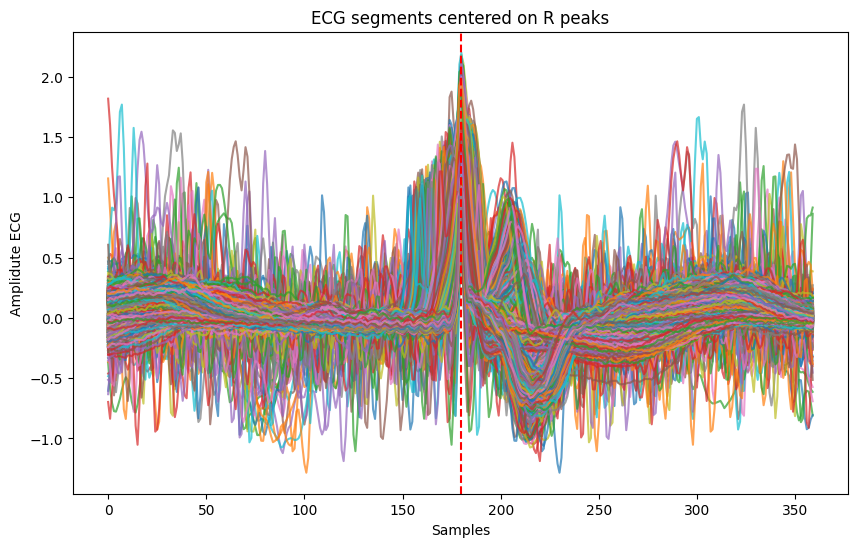

In [162]:
# define the length of the window around R
left = 180   # Samples on the left
right = 180  # Samples on the right

segments = []
for r in peaks:
    if r - left >= 0 and r + right < len(filteredSignalFinal_padded):  # Avoid edge problems
        segment = filteredSignalFinal_padded[r - left : r + right]
        segments.append(segment)

# Convert to array for easier plotting
segments = np.array(segments)

plt.figure(figsize=(10, 6))
for i, segment in enumerate(segments):
    plt.plot(segment, alpha=0.7, label=f"Beat # {i+1}")

plt.axvline(left, color='r', linestyle='--', label="Centered R peak")  # Vertical line for R peak
plt.xlabel("Samples")
plt.ylabel("Amplidute ECG")
plt.title("ECG segments centered on R peaks")
#plt.legend()
plt.show()

In [163]:
len(segments), len(valid_symbols)


(2258, 2266)

Something is wrong, the number of segments manually extracted are not equal to the number of segments annotated by the dataset.
Furthermore, there are several annotations that do not classify the type of beat (for example "+", "~" or "/") and therefore should not be taken into account.


We need to change strategy.

I will take the selected segments from the MIT-BIH dataset discarding all the labels that do not label the beat. In this way I will lose some signals to give as input to the model but at least the labels will be associated correctly and the segments will certainly be significant for the prediction of the beat type.

In [164]:
valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}
valid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]
filtered_samples = annotations.sample[valid_indices]
filtered_symbols = np.array(annotations.symbol)[valid_indices]

window_size = 200  # 100 on left, 100 on right
segments = []
labels = []

for r_peak, label in zip(filtered_samples, filtered_symbols):
    start = max(0, r_peak - window_size // 2)
    end = min(len(filteredSignalFinal), r_peak + window_size // 2)
    segment = filteredSignalFinal[start:end]

    # If the segment does not have the correct length, we discard it
    if len(segment) == window_size:
        segments.append(segment)
        labels.append(label)

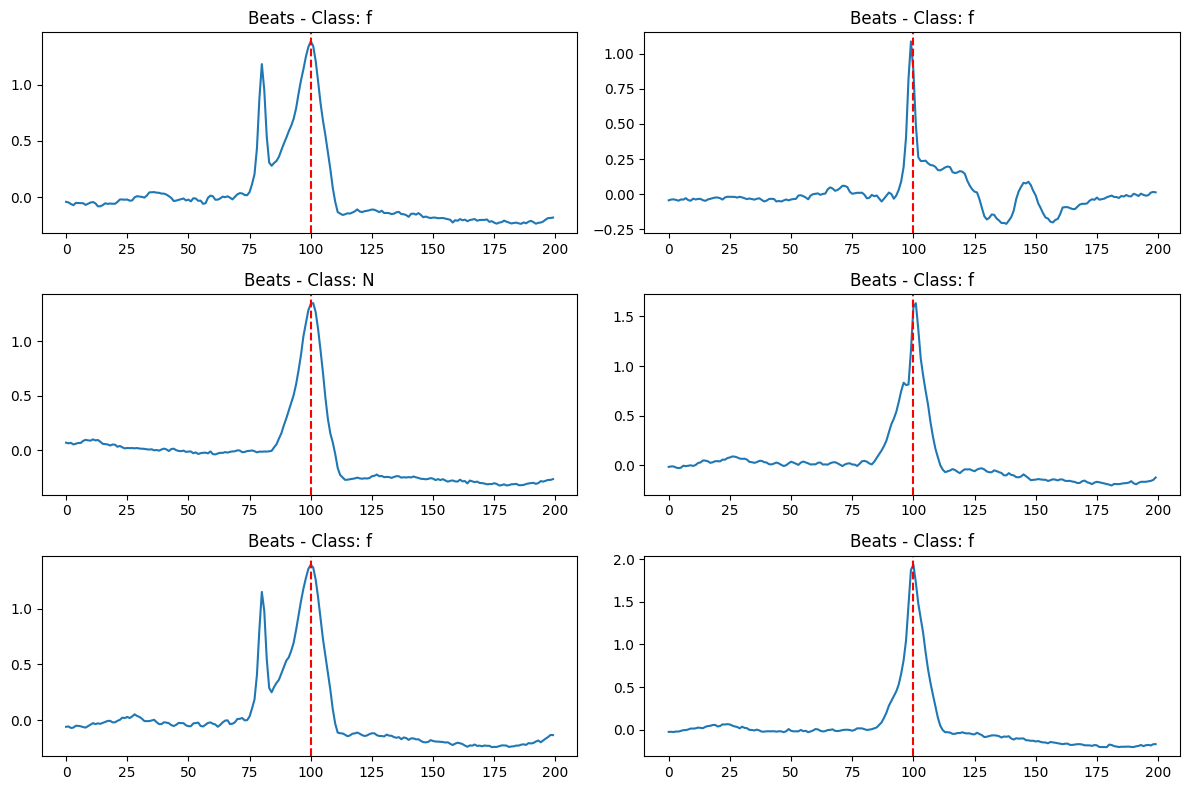

In [170]:
# We randomly choose some segments to plot
num_plots = 6
random_indices = random.sample(range(len(segments)), num_plots)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(3, 2, i)
    plt.plot(segments[idx])
    plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Indicates the center (peak R)
    plt.title(f"Beats - Class: {labels[idx]}")
plt.tight_layout()
plt.show()

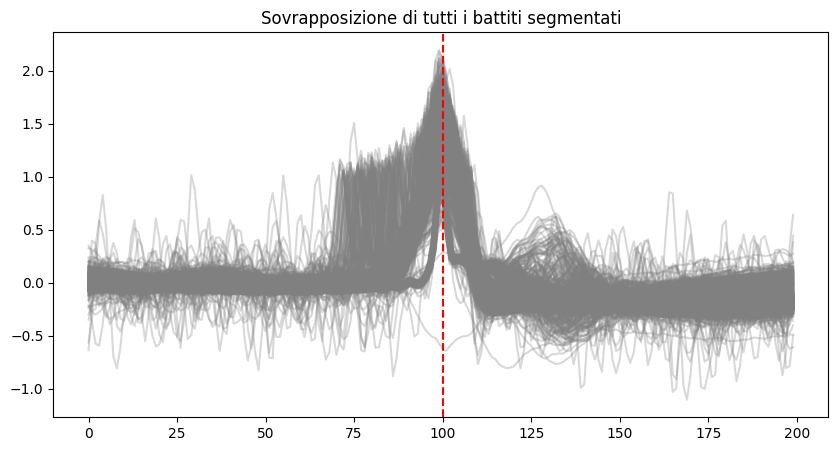

In [166]:
plt.figure(figsize=(10, 5))
for segment in segments:
    plt.plot(segment, color="gray", alpha=0.3)  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title("Sovrapposizione di tutti i battiti segmentati")
plt.show()

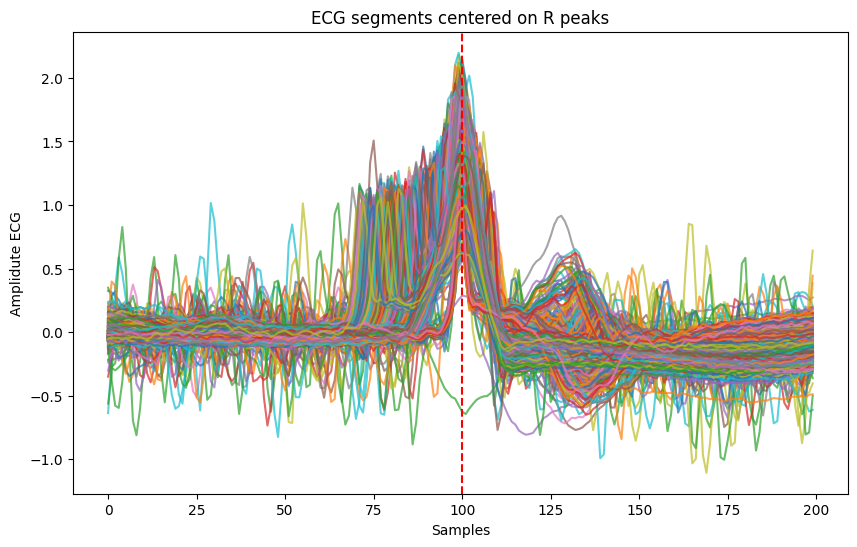

In [167]:
plt.figure(figsize=(10, 6))
for i, segment in enumerate(segments):
    plt.plot(segment, alpha=0.7, label=f"Beat # {i+1}")

plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.xlabel("Samples")
plt.ylabel("Amplidute ECG")
plt.title("ECG segments centered on R peaks")
#plt.legend()
plt.show()

In [168]:
len(segments)

849

### **Feature extraction stage**

### **Classification stage**

### **Evaluation stage**